# Fine-tuning ResNet18 with CCT20

### Imports and CUDA check

In [22]:
import os
import random
import json
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, WeightedRandomSampler, Subset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU for PyTorch.")
else:
    print("CUDA is not available. Using CPU for PyTorch.")

CUDA is available. You can use GPU for PyTorch.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Dataset Preparation

In [4]:
class CCTDataset(Dataset):
    def __init__(self, json_file, images_dir, transform=None, label_mapping=None):
        with open(json_file, 'r') as f:
            data = json.load(f)

        self.images = {img["id"]: img["file_name"] for img in data["images"]}
        self.annotations = data.get("annotations", [])
        self.images_dir = images_dir
        self.transform = transform
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_id = ann["image_id"]
        img_path = os.path.join(self.images_dir, self.images[img_id])
        # print(img_path)

        if not os.path.exists(img_path):
            print(f"Missing image: {img_path}")
            return self.__getitem__((idx + 1) % len(self))
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Failed to open image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))
        
        # Crop the image using bounding box coordinates from json files
        bbox = ann.get("bbox")
        if bbox:
            x, y, w, h = bbox
            x = x / 2
            y = y / 2
            w = w / 2
            h = h / 2
            image = image.crop((x, y, x + w, y + h))
        
        if self.transform:
            image = self.transform(image)
        # label = self.label_mapping[ann["category_id"]]
        label = self.label_mapping.get(ann["category_id"], 0)  # Assigns class 0 if no label is found. This was done to try to fix dataloader stall
        return image, label

In [5]:
def get_label_mapping(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    categories = data["categories"]
    mapping = {category["id"]: idx for idx, category in enumerate(categories)}
    # name_mapping = {idx: category["name"] for idx, category in enumerate(categories)}
    # print("Final name mapping:", name_mapping)
    return mapping

In [6]:
train_json = 'cct20-metadata/train_annotations.json'
cis_val_json = 'cct20-metadata/cis_val_annotations.json'
trans_val_json = 'cct20-metadata/trans_val_annotations.json'
cis_test_json = 'cct20-metadata/cis_test_annotations.json'
trans_test_json = 'cct20-metadata/trans_test_annotations.json'
images_dir = 'cct20-images'

# Create label mapping and determine number of classes
label_mapping = get_label_mapping(train_json)
num_classes = len(label_mapping)

### Dataset Augmentation

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = val_transform

### Assembling train-test sets

In [8]:
cis_test_dataset = CCTDataset(cis_test_json, images_dir, transform=test_transform, label_mapping=label_mapping)
trans_test_dataset = CCTDataset(trans_test_json, images_dir, transform=test_transform, label_mapping=label_mapping)
# test_dataset = ConcatDataset([cis_test_dataset, trans_test_dataset])
test_dataset = cis_test_dataset

train_dataset = CCTDataset(train_json, images_dir, transform=train_transform, label_mapping=label_mapping)
train_dataset = ConcatDataset([trans_test_dataset, train_dataset])

cis_val_dataset = CCTDataset(cis_val_json, images_dir, transform=val_transform, label_mapping=label_mapping)
trans_val_dataset = CCTDataset(trans_val_json, images_dir, transform=val_transform, label_mapping=label_mapping)
val_dataset = ConcatDataset([cis_val_dataset, trans_val_dataset])

print(f"Train dataset size: {len(train_dataset)}")
# image_tensor_1, label_example = train_dataset[0]
# print(image_tensor_1.shape, label_example, "\n")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 38099
Validation dataset size: 5447
Test dataset size: 16395


### Class Imbalance Correction

In [9]:
total_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])
total_class_counts = Counter([label for _, label in total_dataset])

valid_classes = {cls for cls, count in total_class_counts.items() if count >= 500}

filtered_train_indices = [idx for idx, (_, label) in enumerate(train_dataset) if label in valid_classes]
filtered_train_dataset = Subset(train_dataset, filtered_train_indices)

filtered_val_indices = [idx for idx, (_, label) in enumerate(val_dataset) if label in valid_classes]
filtered_val_dataset = Subset(val_dataset, filtered_val_indices)

filtered_test_indices = [idx for idx, (_, label) in enumerate(test_dataset) if label in valid_classes]
filtered_test_dataset = Subset(test_dataset, filtered_test_indices)

print(f"Filtered train dataset size: {len(filtered_train_dataset)}")
print(f"Filtered validation dataset size: {len(filtered_val_dataset)}")
print(f"Filtered test dataset size: {len(filtered_test_dataset)}\n")

num_classes = len(valid_classes)
print("Number of classes after filtering:", num_classes)

# Check if all datasets have the same classes
# for dataset_name, dataset in zip(["Train", "Validation", "Test"],
#                                  [filtered_train_dataset, filtered_val_dataset, filtered_test_dataset]):
#     unique_classes = set(label for _, label in dataset)
#     print(f"{dataset_name} classes: {sorted(unique_classes)}")

Filtered train dataset size: 38023
Filtered validation dataset size: 5443
Filtered test dataset size: 16225

Number of classes after filtering: 13


In [10]:
class RelabelDataset(Dataset):
    def __init__(self, dataset, old_label=14, new_label=12):
        self.dataset = dataset
        self.old_label = old_label
        self.new_label = new_label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if label == self.old_label:
            label = self.new_label
        return image, label

# Apply the relabel wrapper to all datasets
filtered_train_dataset = RelabelDataset(filtered_train_dataset)
filtered_val_dataset = RelabelDataset(filtered_val_dataset)
filtered_test_dataset = RelabelDataset(filtered_test_dataset)

print("Label 14 changed to 12 in all datasets.\n")

# Check if all datasets have the same classes
# for dataset_name, dataset in zip(["Train", "Validation", "Test"],
#                                  [filtered_train_dataset, filtered_val_dataset, filtered_test_dataset]):
#     unique_classes = set(label for _, label in dataset)
#     print(f"{dataset_name} classes: {sorted(unique_classes)}")

Label 14 changed to 12 in all datasets.



In [11]:
# np.set_printoptions(suppress=True)  # Prevent arrays from being printed in scientific notation for better readability

# class_counts = np.zeros(num_classes, dtype=int)
# for _, label in filtered_train_dataset:
#     print(label)
#     class_counts[label] += 1
# print(f"Class counts: {class_counts}\n")

# # Correction to avoid divided by zero error
# for idx in range(len(class_counts)):
#     if class_counts[idx] == 0:
#         class_counts[idx] = 1
#         print("Warning: Some classes have no samples in the training dataset.")

# class_weights = 1.0 / class_counts
# print(f"Class weights: {class_weights}")

# sample_weights = [class_weights[label] for _, label in filtered_train_dataset]

# sampler = WeightedRandomSampler(sample_weights, num_samples=len(filtered_train_dataset), replacement=True)

class_counts = Counter(label for _, label in filtered_train_dataset)
print(f"Class counts: {class_counts}")

class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
print(f"Class weights: {class_weights}")

sample_weights = [class_weights[label] for _, label in filtered_train_dataset]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(filtered_train_dataset), replacement=True)

Class counts: Counter({1: 8280, 4: 6839, 3: 3849, 9: 3361, 0: 3166, 7: 2802, 8: 2308, 6: 1976, 12: 1781, 2: 1778, 5: 881, 10: 563, 11: 439})
Class weights: {7: 0.00035688793718772306, 4: 0.00014622020763269483, 2: 0.0005624296962879641, 0: 0.0003158559696778269, 1: 0.00012077294685990338, 8: 0.0004332755632582322, 3: 0.0002598077422707197, 10: 0.0017761989342806395, 6: 0.0005060728744939271, 9: 0.0002975304968759298, 11: 0.002277904328018223, 5: 0.0011350737797956867, 12: 0.0005614823133071309}


### Data Loader

In [12]:
batch_size = 64

train_loader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(filtered_val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

### BBox Cropping Verification

In [ ]:
# Getting the class names
with open(train_json, 'r') as f:
    data = json.load(f)
idx_to_name = {label_mapping[cat['id']]: cat['name'] for cat in data['categories']}

# Plot 5 random images from the training dataset to verify the crop
indices = random.sample(range(len(train_dataset)), 5)
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for ax, idx in zip(axs, indices):
    img, label = train_dataset[idx]
    
    # Convert tensor image to numpy array and unnormalize
    img = img.cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f'Label: {idx_to_name[label]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Model Import

In [13]:
# Loading the model exactly like the CIFAR-10 ResNet18 model
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes)

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

model = model.to(device)

c:\Users\diogo\Documents\Repos\cifar10-image-classifier\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\diogo\Documents\Repos\cifar10-image-classifier\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
learning_rate = 0.0005

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

### Training Loop

In [15]:
num_epochs = 200
best_f1 = 0.0
epochs_no_improve = 0
patience = 20
train_losses = []
val_losses = []
f1_scores = []

best_model_wts = copy.deepcopy(model.state_dict())  # Saves weight of epoch with best f1-score

In [ ]:
# k-folds initialization
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [16]:
# Original code without k-folds
for epoch in range(1, num_epochs + 1):
    if epoch == 2:
        print(f'Completed the 1st epoch. Something is actually happening!\n')
    
    model.train()
    running_train_loss = 0.0
    # print("Starting the training loop.")  # Prints this statement, but does not reach the next print statement.
    for images, labels in train_loader:
        # print("does not reach this statement.")  # Does not reach this print statement. Problem with the dataloader?
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    scheduler.step()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    f1_scores.append(epoch_f1)


    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}, Val F1-score: {epoch_f1:.4f}')

    if epochs_no_improve >= patience:
        print(f'Early stopping triggered at epoch {epoch}/{num_epochs}: no improvement in {patience} epochs.')
        break

Completed the 1st epoch. Something is actually happening!

Epoch 10/200, Train Loss: 0.201971, Val Loss: 1.406228, Val F1-score: 0.6599
Epoch 20/200, Train Loss: 0.119159, Val Loss: 1.613265, Val F1-score: 0.6820
Epoch 30/200, Train Loss: 0.043499, Val Loss: 2.066979, Val F1-score: 0.6884
Epoch 40/200, Train Loss: 0.034188, Val Loss: 2.422687, Val F1-score: 0.6999
Early stopping triggered at epoch 41/200: no improvement in 20 epochs.


In [ ]:
# New code with k-folds
for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(train_dataset)), np.array([label for _, label in train_dataset]))):
    print(f"Fold {fold + 1}/{n_splits}]")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    for epoch in range(1, num_epochs + 1):
        if epoch == 2:
            print(f'Completed the 1st epoch. Something is actually happening!\n')
        
        model.train()
        running_train_loss = 0.0
        # print("Starting the training loop.")  # Prints this statement, but does not reach the next print statement.
        for images, labels in train_loader:
            # print("does not reach this statement.")  # Does not reach this print statement. Problem with the dataloader?
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)

        scheduler.step()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        epoch_f1 = f1_score(all_labels, all_preds, average='macro')
        f1_scores.append(epoch_f1)


        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}, Val F1-score: {epoch_f1:.4f}')

        # if epochs_no_improve >= patience:
        #     print(f'Early stopping triggered at epoch {epoch}/{num_epochs}: no improvement in {patience} epochs.')
        #     break

In [17]:
model.load_state_dict(best_model_wts)  # Loads weight of best epoch

<All keys matched successfully>

In [18]:
trained_models_dir = 'trained-models'
model_name = 'cct20_resnet_imb1.pth'

os.makedirs(trained_models_dir, exist_ok=True)  # Create folder if it doesn't exist

torch.save(model.state_dict(), os.path.join(trained_models_dir, model_name))

print(f"Model saved to '{os.path.join(trained_models_dir, model_name)}'.")

Model saved to 'trained-models\cct20_resnet_imb1.pth'.


### Training Performance

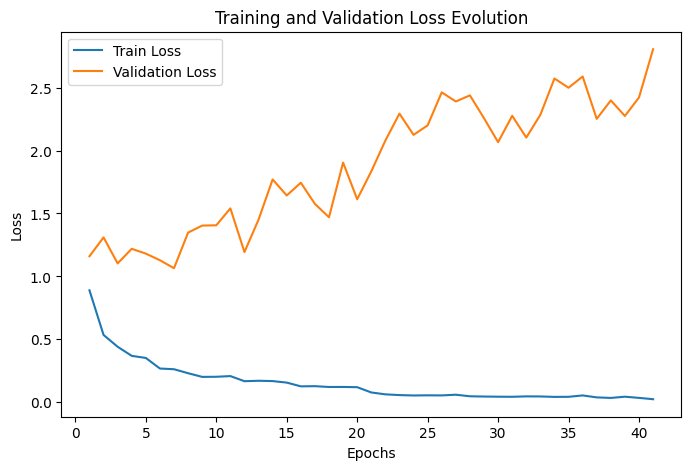

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Evolution')
plt.legend()
plt.show()

### Testing

In [20]:
# Class dictionary for CCT20 to make num to name match
classes_cct = {
    0: 'bobcat',
    1: 'opossum',
    2: 'empty',
    3: 'coyote',
    4: 'raccoon',
    5: 'bird',
    6: 'dog',
    7: 'cat',
    8: 'squirrel',
    9: 'rabbit',
    10: 'skunk',
    11: 'rodent',
    12: 'badger',
    13: 'deer',
    14: 'car',
    15: 'fox'
}

classes_cct_relabeled = {
    0: 'bobcat',
    1: 'opossum',
    2: 'empty',
    3: 'coyote',
    4: 'raccoon',
    5: 'bird',
    6: 'dog',
    7: 'cat',
    8: 'squirrel',
    9: 'rabbit',
    10: 'skunk',
    11: 'rodent',
    12: 'car'  # car went from 14 to 12. Eliminated 12, 13 and 15
}

target_names = [name for _, name in sorted(classes_cct_relabeled.items())]

In [24]:
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_precision = precision_score(all_test_labels, all_test_preds, average="weighted")
test_recall = recall_score(all_test_labels, all_test_preds, average="weighted")
test_f1 = f1_score(all_test_labels, all_test_preds, average="weighted")
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')
print('Classification Report:')
print(classification_report(all_test_labels, all_test_preds, zero_division=0, target_names=target_names))

Test Accuracy: 0.7914
Test Precision: 0.7996
Test Recall: 0.7914
Test F1-Score: 0.7896
Classification Report:
              precision    recall  f1-score   support

      bobcat       0.67      0.78      0.72       909
     opossum       0.92      0.88      0.89      4535
       empty       0.69      0.40      0.51      1180
      coyote       0.63      0.86      0.73      1372
     raccoon       0.72      0.87      0.79      1103
        bird       0.79      0.74      0.76       865
         dog       0.69      0.77      0.73       895
         cat       0.75      0.76      0.75      1672
    squirrel       0.68      0.64      0.66       666
      rabbit       0.91      0.78      0.84      1807
       skunk       0.80      0.73      0.76       194
      rodent       0.69      0.79      0.74       236
         car       0.99      1.00      1.00       791

    accuracy                           0.79     16225
   macro avg       0.76      0.77      0.76     16225
weighted avg       0.80 